In [6]:
import pandas as pd
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVDpp

import os

DATA_DIR = "data"
train_data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
X = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(train_data, reader)
full_train_data = data.build_full_trainset()

In [3]:
from cv_logs import ParameterSearch

import numpy as np
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import RandomizedSearchCV

ITERATIONS = 1000
FOLD = 3

param_grid = {
    "n_factors": np.arange(3, 250, 2),
    "cache_ratings": ["True"],
    "n_epochs": np.arange(100, 1901, 200),
    "lr_all": 10 ** (np.arange(-5, 0, 0.4)),
    "reg_all": 10 ** (np.arange(-5, 0, 0.4)),
    "reg_bu": [0],
    "reg_bi": [0],
}
rs = RandomizedSearchCV(
    SVDpp,
    param_grid,
    measures=["rmse"],
    n_iter=ITERATIONS,
    cv=FOLD,
    n_jobs=-1,
    joblib_verbose=5,
)
rs.fit(data)
ps = ParameterSearch(rs.cv_results)
ps.write("SVDpp-search1.csv")
print(rs.best_score["rmse"])
print(rs.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 46.2min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 90.4min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 108.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 128.9min


0.7234212606911751
{'n_factors': 137, 'cache_ratings': 'True', 'n_epochs': 1500, 'lr_all': 0.0063095734448019684, 'reg_all': 0.10000000000000082, 'reg_bu': 0, 'reg_bi': 0}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 152.7min finished


In [5]:
# SVDpp attempt 1
from predict import predict
from cv_logs import save_model

svdpp_1 = SVDpp(
    **{
        "n_factors": 137,
        "cache_ratings": "True",
        "n_epochs": 1500,
        "lr_all": 0.0063095734448019684,
        "reg_all": 0.10000000000000082,
        "reg_bu": 0,
        "reg_bi": 0,
    }
).fit(full_train_data)

# Public score: 0.66389
predict(svdpp_1, "svdpp_1.csv")
save_model(svdpp_1, "svdpp_1")

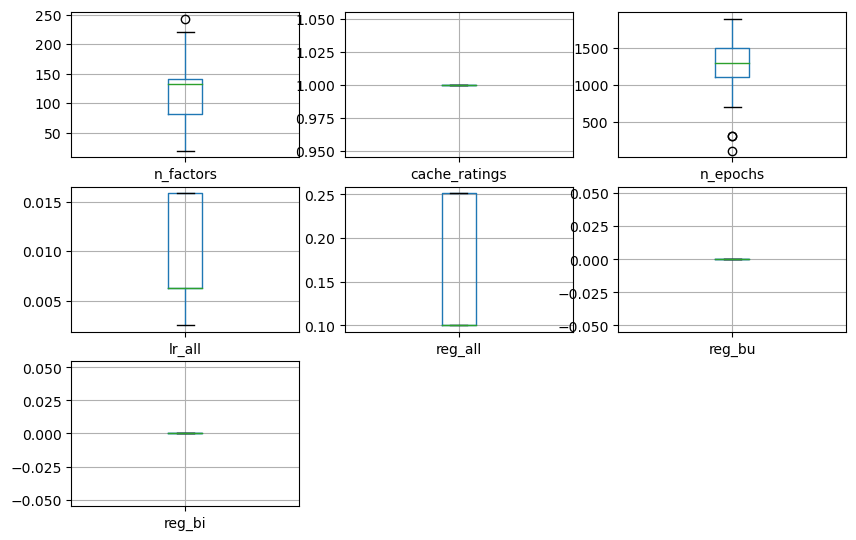

/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1863: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6932: RuntimeWarning: divide by zero encountered in scalar divide
  return ndata / np.sum(np.log((data - location) / scale))
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6955: RuntimeWarning: invalid value encountered in scalar subtract
  return dL_dLocation(shape, location) - dL_dScale(shape, scale)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastruc

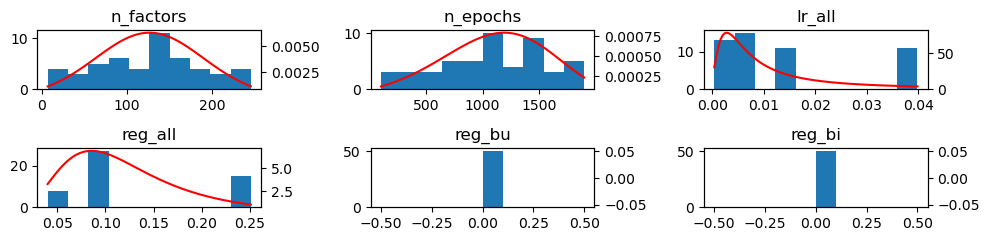

In [1]:
from cv_logs import ParameterSearch

import matplotlib.pyplot as plt

ps = ParameterSearch("cv/SVDpp-search1.csv")
ps.plot_params(25)
plt.show()
best_distributions = ps.get_best_distribution(50)

In [9]:
# 2nd search
from rv import PositiveInt_rv

from surprise.model_selection import RandomizedSearchCV
from surprise.prediction_algorithms.matrix_factorization import SVDpp
import scipy.stats as st

ITERATIONS = 1000
FOLD = 3

int_dist = ["n_factors", "n_epochs"]


dist = ["lr_all", "reg_all"]
param_grid = {
    param: getattr(st, best_distributions[param][0])(*best_distributions[param][2])
    for param in dist
}

INT_MIN = 5
param_grid |= {
    param: PositiveInt_rv(
        getattr(st, best_distributions[param][0])(*best_distributions[param][2]),
        INT_MIN,
    )
    for param in int_dist
}
param_grid |= {
    "cache_ratings": ["True"],
    "reg_bu": [0],
    "reg_bi": [0],
}

rs2 = RandomizedSearchCV(
    SVDpp,
    param_grid,
    measures=["rmse"],
    n_iter=ITERATIONS,
    cv=FOLD,
    n_jobs=-1,
    joblib_verbose=5,
)
rs2.fit(data)
ps2 = ParameterSearch(rs2.cv_results)
ps2.write("SVDpp-search2.csv")
print(rs2.best_score["rmse"])
print(rs2.best_params["rmse"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 63.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 101.1min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 120.9min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 143.4min


0.7163836758856537
{'cache_ratings': 'True', 'lr_all': 0.0034327987866452922, 'n_epochs': 1756, 'n_factors': 52, 'reg_all': 0.14471911603328835, 'reg_bi': 0, 'reg_bu': 0}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 168.7min finished


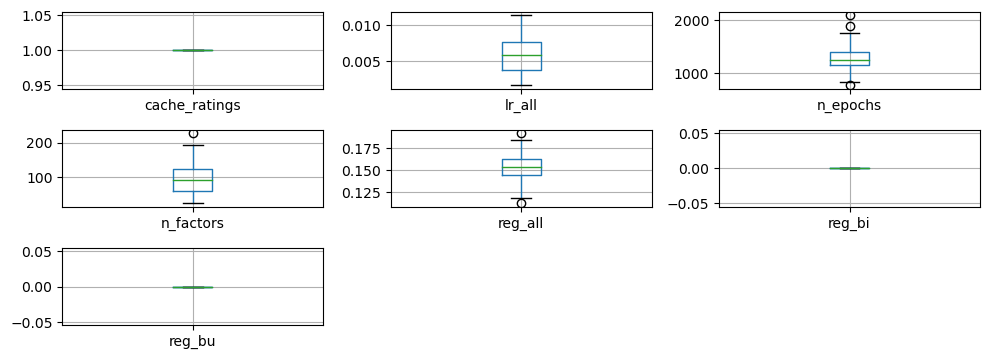

/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1863: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6932: RuntimeWarning: divide by zero encountered in scalar divide
  return ndata / np.sum(np.log((data - location) / scale))
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6955: RuntimeWarning: invalid value encountered in scalar subtract
  return dL_dLocation(shape, location) - dL_dScale(shape, scale)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastruc

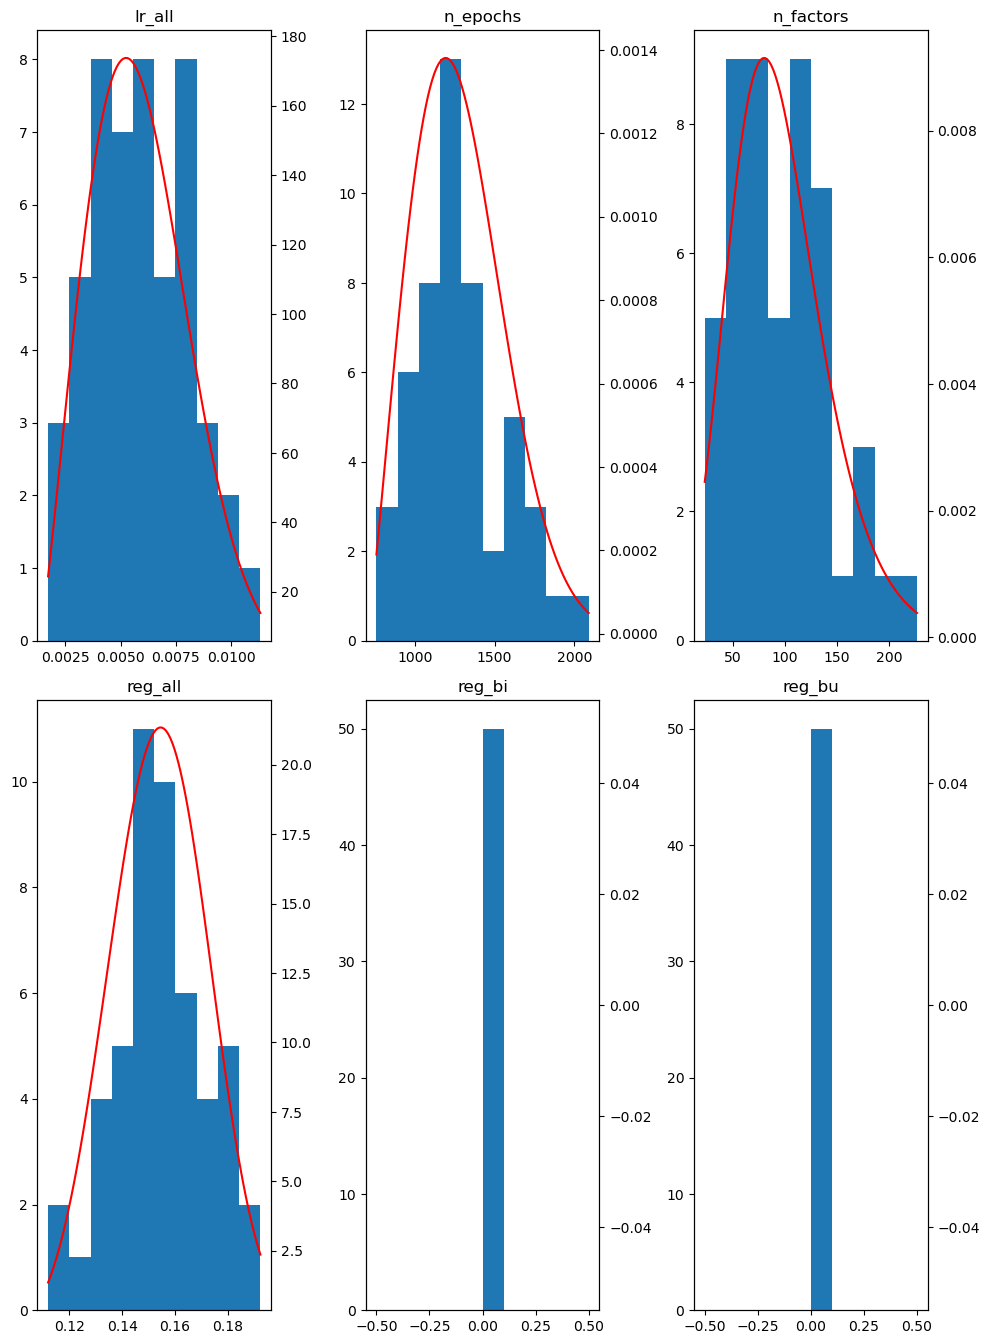

In [5]:
from cv_logs import ParameterSearch
import matplotlib.pyplot as plt

ps2 = ParameterSearch("cv/SVDpp-search2.csv")
ps2.plot_params(50)
plt.show()
best_distributions = ps2.get_best_distribution(50)

In [8]:
# SVDpp attempt 2
from predict import predict
from cv_logs import save_model
from surprise.prediction_algorithms.matrix_factorization import SVDpp

svdpp_2 = SVDpp(
    **{
        "cache_ratings": "True",
        "lr_all": 0.0034327987866452922,
        "n_epochs": 1756,
        "n_factors": 52,
        "reg_all": 0.14471911603328835,
        "reg_bi": 0,
        "reg_bu": 0,
    }
).fit(full_train_data)

# Public score: 0.66538
predict(svdpp_2, "svdpp_2.csv")
save_model(svdpp_2, "svdpp_2")

In [66]:
import numpy as np
from evolution import Evolution

param_grid = {
    "n_factors": np.arange(3, 250, 2),
    "cache_ratings": [True],
    "n_epochs": np.arange(100, 1901, 200),
    "lr_all": 10 ** (np.arange(-5, 0, 0.4)),
    "reg_all": 10 ** (np.arange(-5, 0, 0.4)),
    "reg_bu": [0],
    "reg_bi": [0],
}
const_params = {
    "cache_ratings": [True],
    "reg_bu": [0],
    "reg_bi": [0],
}
int_params = ["n_factors", "n_epochs"]

evo = Evolution(
    SVDpp,
    param_grid,
    int_dist=int_params,
    const_params=const_params,
    model_suffix="_test",
)
evo.evolve(data, 3, 0.25, 8, 3)

RUNNING EVOLUTION 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  24 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.6s finished


RUNNING EVOLUTION 1


/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1863: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6932: RuntimeWarning: divide by zero encountered in scalar divide
  return ndata / np.sum(np.log((data - location) / scale))
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6955: RuntimeWarning: invalid value encountered in scalar subtract
  return dL_dLocation(shape, location) - dL_dScale(shape, scale)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastruc

RUNNING EVOLUTION 2


/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1863: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6932: RuntimeWarning: divide by zero encountered in scalar divide
  return ndata / np.sum(np.log((data - location) / scale))
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6955: RuntimeWarning: invalid value encountered in scalar subtract
  return dL_dLocation(shape, location) - dL_dScale(shape, scale)
/Users/borisleung/anaconda3/envs/stat3009/lib/python3.10/site-packages/scipy/stats/_distn_infrastruc

In [ ]:
from surprise import SVDpp

param_grid = {
    "n_epochs": [2500],
    "lr_all": [0.002, 0.005, 0.01, 0.1],
    "reg_all": [0.4, 0.6, 0.8, 0.2],
    "n_factors": [100, 200, 150, 50],
    "cache_ratings": [True],
}
gs2 = GridSearchCV(
    SVDpp, param_grid, measures=["rmse"], cv=5, n_jobs=-1, joblib_verbose=3
)
gs2.fit(data)
print(gs2.best_score["rmse"])
print(gs2.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 51.5min


0.7299477636156653
{'rmse': {'n_epochs': 2500, 'lr_all': 0.01, 'reg_all': 0.2, 'n_factors': 150}}


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 61.4min finished


In [ ]:
from surprise.model_selection import RandomizedSearchCV

param_grid = {
    "n_epochs": [250, 500, 1000, 1500, 2000, 3500, 5000],
    "lr_all": list(np.arange(0.001, 0.051, 0.002)),
    "reg_all": list(np.arange(0.01, 0.81, 0.025)),
    "n_factors": [10, 25, 50, 100, 150, 200, 500],
    "init_mean": list(range(0, 11)),
    "init_std_dev": [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    "cache_ratings": [True],
}

rs = RandomizedSearchCV(
    SVDpp, param_grid, measures=["rmse"], cv=5, n_jobs=-1, joblib_verbose=3, n_iter=1000
)
rs.fit(data)
print(rs.best_score["rmse"])
print(rs.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed: 97.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 137.7min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 183.0min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 243.0min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed: 325.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 415.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 499.6min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed: 609.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed: 739.9min


0.7110024836896829
{'rmse': {'n_epochs': 250, 'lr_all': 0.047, 'reg_all': 0.01, 'n_factors': 150, 'init_mean': 0, 'init_std_dev': 0.01, 'cache_ratings': True}}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 787.3min finished
